# Technical Test : Minimal RAG Pipeline

by Iman Bensalami

This notebook presents the implementation of a minimal Retrieval-Augmented Generation (RAG) pipeline, as part of the technical assessment.  
This implementation is based solely on the publication available at https://arxiv.org/abs/2411.15594, which serves as the unique knowledge source for the retrieval component.


The pipeline follows the standard RAG structure:
1. Preparation phase
2. PDF preprocessing
3. Chunking Phase
4. Embedding and Indexing

4. Prompt construction
5. Generation with an Open-Source Language Model


The code is fully structured, modular, and commented in English. It is designed to be simple, efficient, and easily testable. All dependencies are open-source.


Before running this notebook, please make sure the following Python packages are installed.  You can install all dependencies at once using the requirements.txt file:

In [ ]:
#!pip install PyMuPDF
#!pip install faiss-cpu
#!pip install transformers accelerate sentencepiece

In [9]:
#imports
import fitz
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import faiss
import textwrap

## Preparation Phase

### Document Selection and Analysis

For this RAG pipeline, we exclusively use the scientific publication [“A Survey on LLM-as-a-Judge” (arXiv:2411.15594)](https://arxiv.org/abs/2411.15594) as the source document. This choice ensures that all answers produced by the system are grounded in a single, reliable, and domain-specific source.

### Document Analysis

The paper is a comprehensive survey that reviews the emerging concept of using large language models (LLMs) as evaluators. Its structure is detailed and systematic, following a clear academic organization:

- An **abstract** that summarizes the goals, challenges, and contributions of the paper
- A **well-structured hierarchy of sections and subsections** (e.g., `1`, `2.1`, `3.2.1`) covering definitions, methodologies, improvements, evaluation strategies, and future directions
- Rich technical content that includes equations, comparative analyses, and implementation suggestions

### Strengths

- **Logical structure**: Sections are clearly numbered, making them ideal anchors for content chunking and metadata assignment.
- **Question-answer alignment**: The main research questions of the survey directly support RAG-based QA.
- **Domain depth**: The paper covers practical use cases, benchmark construction, prompt design strategies, and evaluator models, providing diverse yet connected knowledge points for retrieval.

### Challenges

- **Length and redundancy**: The document is long (~50 pages) and includes repeated phrasing or overlapping content, which can lead to redundancy in chunk embeddings.
- **Technical noise**: Some segments contain citations, footnotes, or formatting artifacts which must be filtered out before chunking and indexing.
- **Non-uniform section lengths**: Some sections (e.g., `5.2`) are very short and contain only titles or bullet points, which are not meaningful standalone for retrieval or answering.






## PDF Preprocessing

In [11]:
#pdf to text conversion
# This function uses PyMuPDF (fitz) to extract raw text (even the text within the images) from each page of the given PDF.
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""

    for page in doc:
        text += page.get_text()

    doc.close()
    return text

#Text extraction
pdf_path="publication.pdf"
text = extract_text_from_pdf(pdf_path)

### What was removed and why:
Before chunking and indexing the document, we apply a light but essential preprocessing step to ensure that the content used for retrieval is meaningful and free from irrelevant noise.

- **Table of Contents**: Automatically generated tables of contents in academic papers often repeat section titles and page numbers, which add no semantic value for question answering and may skew chunk embeddings.
  
- **Headers and Footers**: We removed recurring elements such as "A Survey on LLM-as-a-Judge" and "Vol. 1, No. 1, Article . Publication date: March 2025." These elements are repeated across pages and contain no domain-specific knowledge. Keeping them would introduce unnecessary noise into both the chunks and the retrieval index.

- **In-text Citations**: We also removed inline references such as `[1]`, `[2]`, etc. These citations interrupt sentence flow, are not informative by themselves, and can negatively affect embedding clarity or mislead the retriever.
- **Page-End Markers (.\n\n)**: We removed artificial page-end markers like .\n\n because they often break coherent paragraphs into separate fragments, disrupting the semantic flow of the text. Cleaning them ensures smoother chunking and improves embedding and retrieval quality in the RAG pipeline.

- **Bibliography**: The reference section was excluded from the pipeline. It contains citation metadata that is not useful for answering domain-specific questions and may introduce noise or misleading retrieval results if indexed.

This selective cleaning ensures that our RAG pipeline focuses purely on the substantive academic content of the publication, improving both embedding quality and final response relevance.


In [13]:
#Remove the table of contents section from the raw text
def remove_table_of_contents(text):
    start_match = re.search(r"\bContents\b", text) #match the exact word "Contents" using word boundaries (\b)
    end_match = re.search(r"\n\s*2\s+BACKGROUND AND METHOD", text) # match the beginning of the nexte section, used as the end boundary of the table of contents

    if start_match and end_match and end_match.start() > start_match.end():
        return text[:start_match.start()] + text[end_match.start():]

    return text #else return the original text


text =remove_table_of_contents(text)

In [14]:
# Removing recurring headers and footers from the text
patterns = [", Vol. 1, No. 1, Article . Publication date: March 2025","J. Gu, X. Jiang, Z. Shi, J. Guo, et al.", "A Survey on LLM-as-a-Judge"]

def remove_headers_footers(text, patterns):
  for pattern in patterns:
    text = re.sub(pattern, '', text) #replace the pattenr with ''
  return text


text = remove_headers_footers(text, patterns)

In [15]:
#remove inline citations
def remove_inline_citations(text):
    return re.sub(r'\[\d+(,\s*\d+)*\]', '', text)
    ''' the pattern matches:
            \[ and \] : an opening AND closing square bracket
            \d+      : one or more digits (e.g., "1")
            (,\s*\d+)* : zero or more occurrences of a comma followed by optional whitespace and more digits
    '''


text=remove_inline_citations(text)

In [16]:
#Remove artificial page-end markers .\n\n") from the text
def remove_page_end_markers(text):
    return re.sub(r'\.\s*\n\s*\n', '. ', text)


text=remove_page_end_markers(text)

In [17]:
#Remove the "References" section from the document
def remove_references_section(text):
    # Mot-clé de début de la section références (en majuscules ou minuscules)
    pattern = r'\n\s*REFERENCES\s*\n'  # Define the pattern to locate the start of the "REFERENCES" section

    match = re.search(pattern, text, flags=re.IGNORECASE)
    if match:
        return text[:match.start()].strip() #return everything before it
    else:
        return text


text=remove_references_section(text)

### Manual Removal of Image-Derived Text

After the automated cleaning steps, I manually reviewed the text and removed content derived from images. These image-based segments often included figure captions and visual annotations that were not semantically relevant for retrieval or generation tasks within the RAG pipeline.

This step could not be fully automated, as image-derived text is often irregular and inconsistently extracted by PDF parsers. Therefore, manual review was necessary to ensure high-quality input for chunking and embedding.

In [18]:
# Save the cleaned text to a .txt file for manual editing
with open("publication_preprocessed.txt", "w") as f:
    f.write(text)
f.close()

In [19]:
#manual removal of image-derived segments such as figure captions and text from the images
with open("publication_clean.txt", "r") as f:
    clean_text = f.read()
f.close()

## Chunking Phase

## Logical Paragraph-Based Chunking with Document Structure

To build an efficient and interpretable RAG pipeline, I implemented a custom chunking strategy based on the **logical structure of the document**. Instead of splitting the text arbitrarily (e.g., by fixed token length), I chose to segment it according to **explicit section and subsection headers** (e.g., `1`, `2.1`, `2.2.3`).

This approach offers several key advantages:

-**Semantic coherence**: Each chunk represents a complete and self-contained idea, improving retrieval relevance and generation quality.  
-**Traceability**: Chunks preserve their original section titles as metadata, making it easier to map answers back to their source.

In addition, I added the section number and its first sentence as the chunk title. This enhances navigation and makes it easier to understand the content of each chunk at a glance.


In [20]:
def chunk_by_section(text):
    lines = text.split('\n')
    heading_pattern = r'^\d+(\.\d+)*\s*$' # Pattern to match section headers like "1", "2.3", "4.2.1"

    chunks = []
    current_section_lines = []
    current_section_number = None
    abstract_lines = []  # Lines collected before any numbered section : the abstract

    started_sections = False

    for i, line in enumerate(lines):
        if re.match(heading_pattern, line.strip()):
            if not started_sections:
                # First time we find a section heading ---> capture abstract
                abstract_text = "\n".join(abstract_lines).strip()
                if abstract_text:
                    chunks.append({
                        "title": "Abstract",
                        "content": abstract_text
                    })
                started_sections = True

            # If we already have a section in progress, save it as a chunk
            if current_section_number is not None and current_section_lines:
                full_text = "\n".join(current_section_lines).strip()
                first_line = full_text.split('\n', 1)[0]
                first_sentence = first_line.split('.', 1)[0].strip()
                title = f"{current_section_number} - {first_sentence}" if first_sentence else current_section_number
                chunks.append({
                    "title": title,
                    "content": full_text
                })

            # Start a new section
            current_section_number = line.strip()
            current_section_lines = []

        else:
            # Collect lines into either the abstract or the current section
            if started_sections:
                current_section_lines.append(line)
            else:
                abstract_lines.append(line)

    # Don't forget the last section at the end of the document
    if current_section_number is not None and current_section_lines:
        full_text = "\n".join(current_section_lines).strip()
        first_line = full_text.split('\n', 1)[0]
        first_sentence = first_line.split('.', 1)[0].strip()
        title = f"{current_section_number} - {first_sentence}" if first_sentence else current_section_number
        chunks.append({
            "title": title,
            "content": full_text
        })

    return chunks #list of dictionaries


In [21]:
chunks = chunk_by_section(clean_text)

In [22]:
df_chunks_preview_notebook = pd.DataFrame(chunks[:5])
df_chunks_preview_notebook.head()

,title,content
0,Abstract,"JIAWEI GU1,*, XUHUI JIANG1,*, ZHICHAO SHI1,2,*..."
1,1 - INTRODUCTION,INTRODUCTION\nJudgment is the faculty of think...
2,2 - BACKGROUND AND METHOD,BACKGROUND AND METHOD\nThe capacity of LLMs to...
3,2.1 - In-Context Learning,"In-Context Learning\nTo apply LLM-as-a-Judge, ..."
4,2.1.1 - Generating scores,Generating scores. It is quite intuitive to re...


In [23]:
# This loop calculates the number of words in each chunk's content and adds it as a new field called "word_count".
# This is useful for analyzing chunk size distribution, filtering very short or very long chunks,
# and setting thresholds for embedding or model input length.
for chunk in chunks:
    chunk["word_count"] = len(chunk["content"].split())

In [24]:
df_chunks_preview_notebook = pd.DataFrame(chunks[:5])
df_chunks_preview_notebook.head()

,title,content,word_count
0,Abstract,"JIAWEI GU1,*, XUHUI JIANG1,*, ZHICHAO SHI1,2,*...",302
1,1 - INTRODUCTION,INTRODUCTION\nJudgment is the faculty of think...,811
2,2 - BACKGROUND AND METHOD,BACKGROUND AND METHOD\nThe capacity of LLMs to...,421
3,2.1 - In-Context Learning,"In-Context Learning\nTo apply LLM-as-a-Judge, ...",119
4,2.1.1 - Generating scores,Generating scores. It is quite intuitive to re...,226


### Filtering Short Chunks

After chunking the document by logical sections, we filtered out all chunks with fewer than 6 words. Very short chunks often result from section headers, broken formatting, or incomplete paragraphs. These chunks rarely contain useful semantic information and can degrade the quality of retrieval and embedding.

By applying this threshold, we ensure that each chunk has enough context to be meaningful during similarity search and language model generation, while also keeping the vector index cleaner and more efficient.


In [25]:
# We define a minimum threshold of 6 words to retain only informative content.

MIN_WORDS = 6  # Minimum number of words required for a chunk to be kept

# Create a new list containing only chunks that meet the minimum word count
filtered_chunks = [
    chunk for chunk in chunks
    if len(chunk["content"].split()) >= MIN_WORDS
]

# Update the chunk list
chunks = filtered_chunks

### Splitting Long Chunks with Overlap

To ensure each chunk fits within the maximum input length of embedding models or language models, we split any chunk exceeding 300 words into smaller, overlapping sub-chunks. We applied an overlap of 50 words between consecutive sub-chunks to preserve context across boundaries and avoid losing important transitional information.

This approach strikes a balance between chunk size, model compatibility, and semantic continuity — improving both retrieval accuracy and generative coherence in the RAG pipeline.


In [26]:
#Split long chunks into smaller overlapping sub-chunks (word-based)
def split_chunks_by_words_list(chunks, max_words=300, overlap=50):
    def split_one_chunk(text, title):
        words = text.split()
        sub_chunks = []
        start = 0
        index = 1

        while start < len(words):  # Sliding window approach: move in steps with overlap
            end = start + max_words
            chunk_words = words[start:end]
            chunk_text = " ".join(chunk_words)
            sub_chunks.append({
                "title": f"{title} [{index}]",   # Sub-chunk titles are numbered
                "content": chunk_text,
                "word_count": len(chunk_words)
            })
            index += 1
            start += max_words - overlap
        return sub_chunks

    final_chunks = []

    for chunk in chunks:
        title = chunk["title"]
        content = chunk["content"]
        word_count = len(content.split())

        if word_count > max_words: # If the chunk is too long, split it
            final_chunks.extend(split_one_chunk(content, title))

        else:
            chunk["word_count"] = word_count
            final_chunks.append(chunk)

    return final_chunks


In [27]:
split_chunks = split_chunks_by_words_list(chunks)  # 'chunks' is a list of dictionaries (title + content+ word_count)

# From this point on, 'chunks' refers to the length-constrained, overlap-aware version
chunks = split_chunks

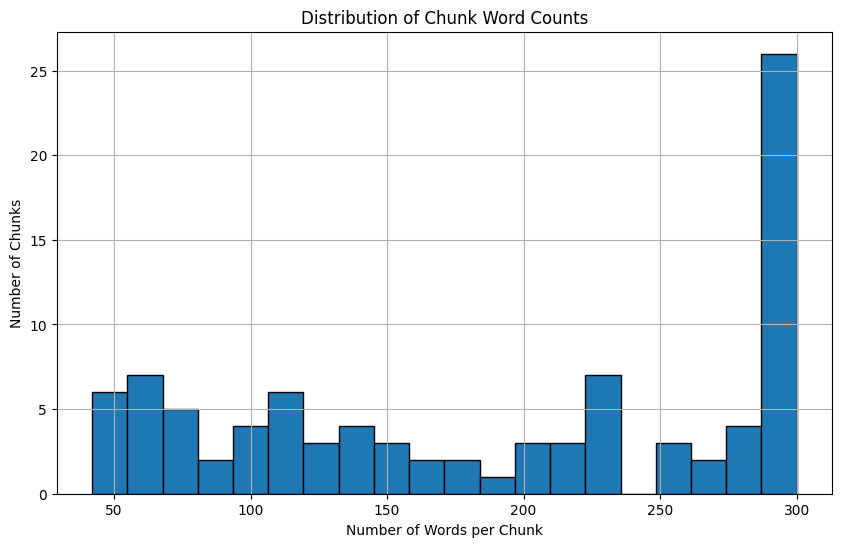

In [28]:
#VISUALIZATION

# Extract word counts
word_counts = [chunk["word_count"] for chunk in chunks]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, edgecolor='black')
plt.title("Distribution of Chunk Word Counts")
plt.xlabel("Number of Words per Chunk")
plt.ylabel("Number of Chunks")
plt.grid(True)
plt.show()

## Embedding and Indexation

To enable efficient semantic search, each chunk was transformed into a vector using the `all-MiniLM-L6-v2` embedding model from the `sentence-transformers` library. We enriched the input by combining each chunk’s title with its content to enhance context understanding. These embeddings were stored in a FAISS index, which allows for fast and scalable similarity search. In parallel, we preserved metadata (title and content) to retrieve and display the full text of each chunk after retrieval. This step forms the backbone of the retrieval process in the RAG pipeline.


In [41]:
# Loading the embedding model
# We use a lightweight sentence transformer to convert text into semantic vector representations.
model = SentenceTransformer("all-MiniLM-L6-v2")

# Each text includes both the section title and its content to improve semantic context.
texts = [f"{chunk['title']}\n{chunk['content']}" for chunk in chunks]

#generating embeddings for all chunks
embeddings = model.encode(texts, convert_to_numpy=True)



In [42]:
#FAISS index
dimension = embeddings.shape[1] #This is required by FAISS to create an index with the appropriate vector size.

index = faiss.IndexFlatL2(dimension) ## FAISS will store the embedding vectors and perform similarity search based on L2 distance.

index.add(embeddings)  # Add all chunk vectors to the index

In [43]:
# Store metadata for retrieval
metadata = [{"title": chunk["title"], "content": chunk["content"]} for chunk in chunks]

### Retrieval Test: Query Embedding and Top-k Semantic Search

In [44]:
query = "What are the limitations of using LLMs as judges?"
query_embedding = model.encode([query]) # This ensures the query and the chunks are in the same vector space.


#Perform semantic search in the FAISS index
# This retrieves the top 3 most similar chunks (based on L2 distance) to the query embedding.
D, I = index.search(np.array(query_embedding), k=3)
 # I --> Index positions of top 3 matches in the original data
 # D --> Distances to those 3 matches (smaller = better)


#Display the top-matching chunks
for idx in I[0]:
    print(metadata[idx]["title"])
    print(metadata[idx]["content"][:300])
    print("---")

7 - APPLICATIONS
APPLICATIONS
LLMs’ abilities as evaluators have gained widespread recognition in specialized fields, especially in
complex, qualitative areas like legal texts, mathematical reasoning, and scientific research .
This section reviews recent developments in LLM-as-a-judge applications across finance, la
---
8 - CHALLENGES
CHALLENGES
In this chapter, we explore the key challenges that arise when utilizing LLMs for evaluation
tasks, particularly in the context of LLM-as-a-Judge. Despite their growing capabilities, LLMs still
face significant issues related to reliability, robustness, and their backbone models’ limitati
---
Abstract [2]
a novel benchmark designed for this purpose. To advance the development and real-world deployment of LLM-as-a- Judge systems, we also discussed practical applications, challenges, and future directions. This survey serves as a foundational reference for researchers and practitioners in this rapidly 
---


## Prompt Construction

### Prompt Construction Strategy

This function serves as the critical link between retrieval and generation in the RAG pipeline. It takes a user question, encodes it into a vector using the same embedding model used during indexing, and retrieves the top-k most semantically similar chunks from the FAISS index. These chunks are then formatted into a structured prompt.

In [45]:
def retrieve_and_construct_prompt(question, model, index, metadata, top_k=5):
    """
    Returns:
        prompt (str): A formatted prompt to be passed to the LLM.
        selected_chunks (list): The retrieved chunks used in the prompt.
    """

    # Encode the question into a semantic vector
    query_embedding = model.encode([question], convert_to_numpy=True)

    # Perform top-k semantic search in the FAISS index
    distances, indices = index.search(np.array(query_embedding), top_k)
    selected_chunks = [metadata[i] for i in indices[0]]

    # Build a structured prompt including titles, content, and the question
    prompt = "### CONTEXT\n"
    for chunk in selected_chunks:
        prompt += f"\n## {chunk['title']}\n{chunk['content']}\n"
    prompt += f"\n### QUESTION\n{question}\n"
    prompt += "### ANSWER :\n"

    return prompt, selected_chunks


### Prompt Construction test

In [46]:
user_question = "What are the limitations of using LLMs as judges?"

# Retrieve the top-5 most relevant chunks and construct a structured prompt
prompt, sources = retrieve_and_construct_prompt(
    question=user_question,
    model=model,
    index=index,
    metadata=metadata,
    top_k=5
)

print(prompt) # This prompt will be then passed to the language model for answer generation.

### CONTEXT

## 7 - APPLICATIONS
APPLICATIONS
LLMs’ abilities as evaluators have gained widespread recognition in specialized fields, especially in
complex, qualitative areas like legal texts, mathematical reasoning, and scientific research .
This section reviews recent developments in LLM-as-a-judge applications across finance, law,
science, and other industries, investigating how domain knowledge and LLM evaluators can further
expand their impact in critical areas.

## 8 - CHALLENGES
CHALLENGES
In this chapter, we explore the key challenges that arise when utilizing LLMs for evaluation
tasks, particularly in the context of LLM-as-a-Judge. Despite their growing capabilities, LLMs still
face significant issues related to reliability, robustness, and their backbone models’ limitations.
Understanding these challenges is crucial for advancing the use of LLMs in a fair, consistent, and
reliable manner. We address these concerns under three main themes: reliability, robustness, and
the need

## Generation with an Open-Source Language Model




To complete the RAG pipeline, we use an open-source generative model — TinyLlama 1.1B — loaded via Hugging Face's `transformers` library. The tokenizer converts text into model-ready tokens, while the model generates the answer based on the constructed prompt. We use the `pipeline("text-generation")` utility for simplicity and readability.


In [47]:
#Load the open-source language model and tokenizer (TinyLlama)

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# device_map="auto" will use GPU if available, otherwise CPU
# torch_dtype="auto" lets the model pick the most efficient data type
model_generation = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)

# Create a text-generation pipeline
# This wraps the model and tokenizer into a single callable object soo we can pass in a prompt and receive generated text.
generator = pipeline("text-generation", model=model_generation, tokenizer=tokenizer)





Device set to use cuda:0


### Clean Answer Generation

To ensure the model’s output remains concise and relevant, we implemented a post-processing function that trims off unwanted continuations. Open-source models like TinyLlama often continue generating text beyond the answer (e.g., repeating the context or sections). To prevent this, we check for specific stop-tokens (e.g., `"##"`, `"QUESTION"`) and truncate the output accordingly. This approach improves clarity, avoids redundancy, and ensures the response stays focused on the original question.


Parameters breakdown:
- Temperature 0.3 : Lower = safer, more conservative responses
- max_new_tokens=350 : Limits the maximum number of tokens the model is allowed to generate
- do_sample=False : Disables random sampling.

In [48]:
#Clean answer generation with stop-token trimming
def generate_answer_with_cleaning(generator, prompt, stop_tokens=["##", "###", "QUESTION", "CONTEXT"]):

    # Generate raw text from the language model
    response = generator(prompt, max_new_tokens=350, do_sample=False, temperature=0.3)

    # Extract only the new text generated after the original prompt
    generated = response[0]['generated_text'][len(prompt):].strip()

    # Truncate the output at the first unwanted continuation marker (if any)
    for stop_token in stop_tokens:
        if stop_token in generated:
            generated = generated.split(stop_token)[0].strip()

    wrapped = textwrap.fill(generated, width=100, replace_whitespace=False)
    return wrapped


Once the prompt is constructed and the model is loaded, we pass the prompt through the `generate_answer_with_cleaning` function. This ensures the response is not only generated accurately but also cleaned of any repeated sections or unwanted formatting. The final answer is then displayed, marking the completion of the Retrieval-Augmented Generation (RAG) pipeline.


In [49]:
answer = generate_answer_with_cleaning(generator, prompt)

print("GENERATED ANSWER:\n")
print(answer)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


GENERATED ANSWER:

The limitations of using LLMs as judges are not fully effective in improving the evaluation
performance or mitigating biases. The limitations and challenges will be further discussed in
Section 8. Based on the current experimental analysis, an empirical strategy for pairwise comparison
evaluation tasks is to select more powerful LLMs and to adopt two evaluation strategies: one is
swapping the positions of the evaluation contents, the other is taking the majority voting results
from multiple rounds of evaluation, which can effectively mitigate biases. As for improving the
alignment with humans, further exploration is still needed.


## Tests

In [50]:
user_question = "What are the two main challenges that hinder the widespread application of the 'LLM-as-a-Judge' approach?"

prompt, sources = retrieve_and_construct_prompt(
    question=user_question,
    model=model,
    index=index,
    metadata=metadata,
    top_k=5
)
answer = generate_answer_with_cleaning(generator, prompt)
print("GENERATED ANSWER:\n")
print(answer)


GENERATED ANSWER:

1. Reliability: LLMs' ability to mimic human-like reasoning and thinking processes is a significant
challenge. LLMs' performance can vary significantly across different tasks, making it challenging to
establish a reliable evaluation method.
2. Robustness: LLMs' performance can also vary significantly
across different tasks, making it challenging to establish a robust evaluation method.


In [51]:
user_question = "How does LLM-as-a-Judge differ from traditional evaluation methods?"

prompt, sources = retrieve_and_construct_prompt(
    question=user_question,
    model=model,
    index=index,
    metadata=metadata,
    top_k=5
)
answer = generate_answer_with_cleaning(generator, prompt)
print("GENERATED ANSWER:\n")
print(answer)

GENERATED ANSWER:

LLM-as-a-Judge differs from traditional evaluation methods in several ways. Firstly, LLM-as-a-Judge
is a
system that evaluates the performance of a language model, rather than a human. This means that
LLM-as-a-Judge
is not evaluated by humans, but rather by a machine. Secondly, LLM-as-a-Judge is
designed to evaluate the
performance of a language model in a specific task, rather than evaluating
the performance of a human
judge. This means that LLM-as-a-Judge is not evaluated by humans, but
rather by a machine. Thirdly, LLM-as-a-Judge
is designed to be more robust and reliable than
traditional evaluation methods. This is because LLM-as-a-Judge
is designed to evaluate the
performance of a language model in a specific task, rather than evaluating the
performance of a
human judge. This means that LLM-as-a-Judge is more likely to identify and mitigate biases and
vulnerabilities in the language model. Finally, LLM-as-a-Judge is designed to be scalable and
adaptable to diffe

In [52]:
user_question = "What are the proposed future directions for improving LLM-as-a-Judge?"

prompt, sources = retrieve_and_construct_prompt(
    question=user_question,
    model=model,
    index=index,
    metadata=metadata,
    top_k=5
)
answer = generate_answer_with_cleaning(generator, prompt)
print("GENERATED ANSWER:\n")
print(answer)

GENERATED ANSWER:

The proposed future directions for improving LLM-as-a-Judge include:

1. Improving the alignment
with humans: The current evaluation methods are not fully aligned with humans, and further
exploration is needed to improve the evaluation performance and mitigate biases.

2. Developing
evaluation methodologies: The development of evaluation methodologies has evolved significantly with
the advent of GPT-4, enabling more scalable and flexible approaches to LLM-as-a-Judge systems. These
evaluation paradigms typically rely on interactions with the environment to obtain feedback, which
forms the foundation for self-evolution signals.

3. Enhancing AI’s intelligent performance: If we
can establish reliable LLM-as-a-Judge in the future, and further enhance AI’s intelligent
performance as a World Model, using. World Model-as-a-Judge could make our simulations of the real
world more realistic and widely reliable.

4. Expanding applications: LLMs’ abilities as evaluators
have gai

# Future Improvements

To enhance the RAG pipeline, several extensions could be considered:

- **Query Reformulation**: Automatically rewrite user queries to better match document language, improving retrieval accuracy.
- **Adaptive Retrieval**: Dynamically adjust the number of retrieved chunks based on query type or confidence scores.
- **Grounded Evaluation**: Integrate factuality checks to ensure that generated answers are strictly based on retrieved evidence.

These improvements would make the pipeline more robust, accurate, and closer to production-level applications.
